# Динамические сети

**Цель работы:** исследование свойств некоторых динамических нейронных сетей,
алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

| <!-- --> | <!-- --> |
|:---------|:---------|
| Студент    | Почечура А.А.   |
| Группа   | М8О-406Б-20  |
| Вариант    | 18   |

Подключаем библиотеки, которые нам понадобятся в данной работе.

In [22]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
from collections import deque
from sklearn.model_selection import train_test_split

## Этап 2: Использоват сеть прямого распространения с распределенным запаздыванием для распознавания динамических образов.


Сгенерируем датасет обущеющего множества соответственно варианту задания. Отобразим полученные данные на графике.

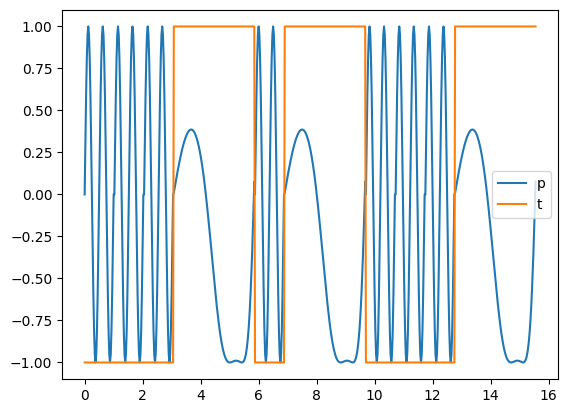

In [33]:
h = 0.025
k1 = torch.arange(0, 1+h, h)
p1 = torch.sin(4*torch.pi*k1)
t1 = -torch.ones_like(k1)

k2 = torch.arange(0.01, 2.77+h, h)
p2 = torch.sin(-torch.sin(k2)*k2**2+k2)
t2 = torch.ones_like(k2)

R = [3,1,3]

p = torch.cat((torch.tile(p1, (R[0],)), p2, torch.tile(p1, (R[1],)), p2, torch.tile(p1, (R[2],)), p2), 0)
t = torch.cat((torch.tile(t1, (R[0],)), t2, torch.tile(t1, (R[1],)), t2, torch.tile(t1, (R[2],)), t2), 0)
x = torch.arange(p.shape[0]) * h
plt.plot(x, p, label='p')
plt.plot(x, t, label='t')
plt.legend()
plt.show()

Зададим *x_train* и *y_train* с помощью метода "скользящего окна" размера *D = 5*.

In [34]:
def data(x, y, D):
  x_train = torch.zeros((x.shape[0]-D, D))
  y_train = torch.zeros((y.shape[0]-D, D))
  for i in range(0, x.shape[0]-D):
    x_train[i] = x[i:i+D]
    y_train[i] = y[i:i+D]
  return x_train, y_train

D = 5
x_train, y_train = data(p, t, D)

Создадим класс TDL, с помощью которого будет осуществляться скольжение по входному сигналу.

In [35]:
class TDL(nn.Module):
    def __init__(self, in_features, delay=1):
        super().__init__()
        self.in_features = in_features
        self.delay = delay
        self.line = deque()
        self.clear()

    def clear(self):
        self.line.clear()
        for i in range(self.delay):
            self.line.append(torch.zeros(self.in_features))

    def push(self, input):
        self.line.appendleft(input)

    def forward(self, input=None):
        return self.line.pop()

Теперь зададим класс TDNN.

In [36]:
class TDNN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, delay):
        super().__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features

        self.line = TDL(in_features, delay)

        self.w1 = torch.nn.Parameter(torch.randn(in_features, hidden_features))
        self.w2 = torch.nn.Parameter(torch.randn(hidden_features, out_features))

        self.b1 = torch.nn.Parameter(torch.randn(hidden_features))
        self.b2 = torch.nn.Parameter(torch.randn(out_features))

    def clear(self):
        self.line.clear()

    def forward(self, x):
        res = torch.tanh(self.line() @ self.w1 + self.b1)
        res = res @ self.w2 + self.b2
        self.line.push(x_train.clone().detach())
        return res

Далее идёт класс Trainer, с помощью которого мы тренируем нашу сеть. Иницализируем класс параметрами обучения и определяем порядок обучения.

In [37]:
class Trainer():
  def __init__(self,  net, loss_f, learning_rate=1e-3,
              epoch_amount=10,
              optim=torch.optim.Adam):

    self.loss_f = loss_f
    self.learning_rate = learning_rate
    self.epoch_amount = epoch_amount
    self.optim = optim
    self.model = net

    self.train_loss = []

  def predict(self, X):
    with torch.no_grad():
      return self.model(X)

  def fit(self, x_train, y_train):
    Net = self.model
    optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

    with tqdm(desc="epoch", total=self.epoch_amount) as bar:
      for epoch in range(self.epoch_amount):
        optimizer.zero_grad()
        predicted_values = Net(x_train)
        loss1 = self.loss_f(predicted_values, y_train)
        loss1.backward()
        optimizer.step()

        self.train_loss.append(loss1.detach().numpy())

        bar.set_postfix({"Loss_train": loss1.detach().numpy()})
        bar.update()

Производим обучение модели. Количество нейронов в сети равно 8.

In [48]:
net = TDNN(5, 8, 1, 4)
train = Trainer(net, nn.MSELoss(), 0.1, 100, torch.optim.Adam)
train.fit(x_train, y_train)

epoch: 100%|██████████| 100/100 [00:00<00:00, 252.62it/s, Loss_train=0.068811566]


Отобразим на графике значения ошибок, полученных в процессе обучения модели.

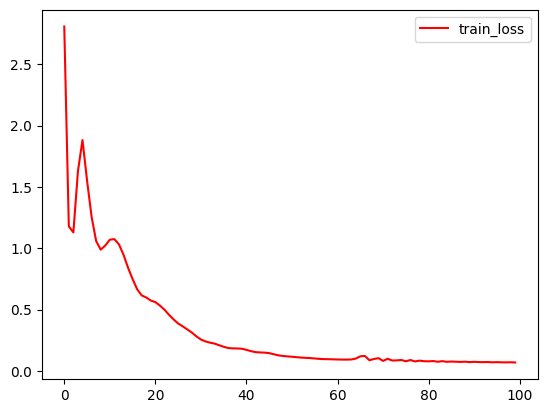

In [49]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.legend()
plt.show()

Отобразим на графике значения ошибок, полученных в процессе обучения модели.

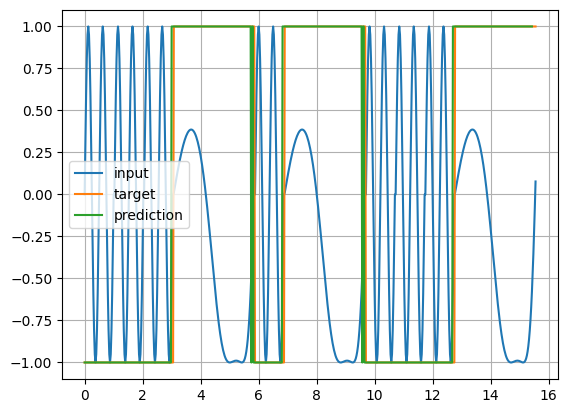

In [50]:
preds = np.sign(train.predict(x_train))
plt.plot(x, p, label='input')
plt.plot(x, t, label='target')
plt.plot(x[:-D], preds[:,0], label='prediction')

plt.grid()
plt.legend()
plt.show()

## Этап 3. Использовать нелинейную авторегрессионную сеть с внешними входами для аппроксимации траектории динамической системы и выполнения многошагового прогноза.


Сгенерируем датасет обущеющего множества соответственно варианту задания. Отобразим полученные данные на графике.

torch.Size([1001])
torch.Size([1001])


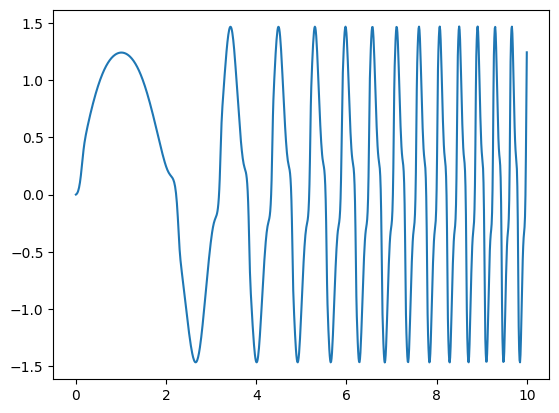

In [51]:
h = 0.01
t = torch.arange(0, 10+h, h)
x = torch.Tensor([torch.sin(i**2 - 2*i + 3) for i in t])
y = torch.ones(x.shape[0])
y[0] = 0
for i in range(x.shape[0]-1):
    y[i+1]=(y[i] / (1 + y[i]**2) + x[i]**3)

print(x.shape)
print(y.shape)
plt.plot(t, y)
plt.show()

Зададим *x_train* и *y_train* с помощью метода "скользящего окна" размера *D = 5*.

In [52]:
def data(x, y, D):
  x_train = torch.zeros((x.shape[0]-D, D))
  y_train = torch.zeros((y.shape[0]-D, 1))
  for i in range(0, x.shape[0]-D):
    x_train[i] = x[i:i+D]
    y_train[i] = y[i+D]
  return x_train, y_train

D = 5
x_train, y_train = data(x, y, D)

Создадим класс NARX.

In [53]:
class NARX(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, delay1, delay2):
        super(NARX, self).__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features

        self.line1 = TDL(in_features, delay1)
        self.line2 = TDL(out_features, delay2)

        self.w1 = torch.nn.Parameter(torch.randn(in_features, hidden_features))
        self.w2 = torch.nn.Parameter(torch.randn(hidden_features, out_features))
        self.w3 = torch.nn.Parameter(torch.randn(out_features, hidden_features))

        self.b1 = torch.nn.Parameter(torch.randn(hidden_features))
        self.b2 = torch.nn.Parameter(torch.randn(out_features))

    def clear(self):
        self.line1.clear()
        self.line2.clear()

    def forward(self, input):
        res = torch.tanh(self.line1() @ self.w1 + self.line2() @ self.w3 + self.b1)
        res = res @ self.w2 + self.b2
        self.line1.push(input.clone().detach()) # сохранять будем копии
        self.line2.push(res.clone().detach())
        return res

Далее идёт класс Trainer, с помощью которого мы тренируем нашу сеть. Иницализируем класс параметрами обучения и определяем порядок обучения.

In [54]:
class Trainer():
  def __init__(self,  net, loss_f, learning_rate=1e-3,
              epoch_amount=10,
              optim=torch.optim.Adam):

    self.loss_f = loss_f
    self.learning_rate = learning_rate
    self.epoch_amount = epoch_amount
    self.optim = optim
    self.model = net

    self.train_loss = []

  def predict(self, X):
    with torch.no_grad():
      predicted = torch.ones(X.shape[0], 1)
      for i in range(X.shape[0]):
          predicted[i,0] = self.model(x_train[i].view(1,-1))
      return predicted

  def fit(self, x_train, y_train):
    Net = self.model
    optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

    with tqdm(desc="epoch", total=self.epoch_amount) as bar:
      for epoch in range(self.epoch_amount):
        epoch_loss = []
        for i in range(x_train.shape[0]):
          predicted_values = Net(x_train[i].view(1,-1))
          loss1 = self.loss_f(predicted_values, y_train[i])
          epoch_loss.append(loss1.detach().numpy())
          loss1.backward()
          optimizer.step()
          optimizer.zero_grad()

        self.train_loss.append(np.mean(epoch_loss))

        bar.set_postfix({"Loss_train": np.mean(epoch_loss)})
        bar.update()

Производим обучение модели.

In [61]:
net = NARX(5, 10, 1, 3, 3)
train = Trainer(net, nn.MSELoss(), 0.001, 70, torch.optim.Adam)
train.fit(x_train, y_train)

epoch: 100%|██████████| 70/70 [01:14<00:00,  1.06s/it, Loss_train=0.0224]


Отобразим на графике значения ошибок, полученных в процессе обучения модели.

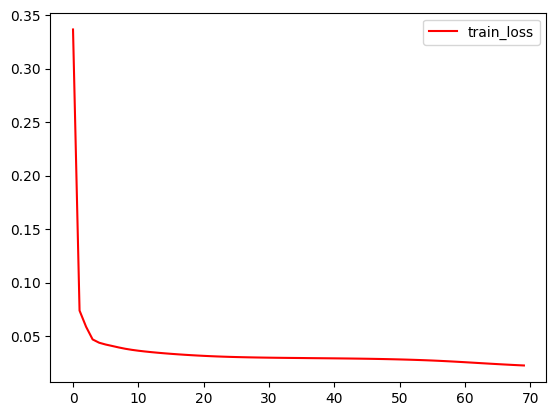

In [62]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.legend()
plt.show()

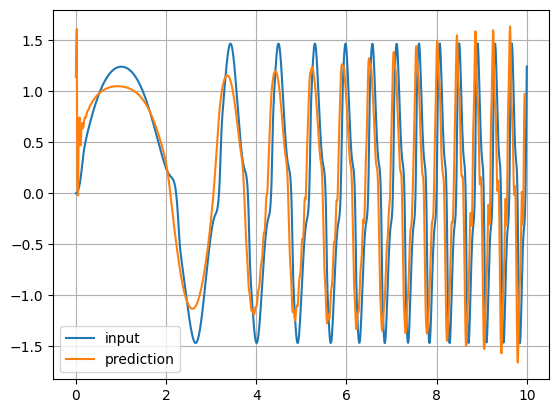

In [63]:
preds = train.predict(x_train)
plt.plot(t, y, label='input')
plt.plot(t[:-D], preds[:,0], label='prediction')

plt.grid()
plt.legend()
plt.show()

**Вывод**: В процессе выполнения данной лабораторной работы я научился самостоятельно реализовывать и практически применять динамические нейронные сети. Интересно было разбираться в тонкостях реализации данных сетей. Благодаря тому, что данные сети могут запоминать прошлые данные, их можно использовать для решения нестандартных задач (например: преобразование акустического сигнала).